# Prédictions Emissions

Maintenant qu'on a préparé notre dataset et nos variables lors d'une première partie, on va pouvoir passer à l'objectif de ce projet, c'est-à-dire la prédiction des valeurs de consommation énergétique et d'émission de CO2. Dans ce notebook, on se concentrera sur la variable d'émission de CO2, TotalGHGEmission qu'on a sélectionnée précédemment.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math 

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split

## Choix du modèle 

### Première approche simple

Pour commencer, il va falloir quel modèle nous allons utiliser pour faire nos prédictions. Pour cela, nous allons en tester plusieurs puis on comparera leurs résultats sur une première itération sans modifier les paramètres par défaut. On sélectionnera ainsi les meilleurs modèles, qu'on essayera par la suite d'améliorer en modifiant les hyperparamètres. Commençons donc par appliquer divers modèles d'apprentissage afin de trouver les plus performants sur notre problème.

Avant de commencer, on va devoir séparer notre dataset en train/test afin de tester les performances.

In [2]:
ml_data = pd.read_csv('ml_data_prop.csv')
ml_data

,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,BuildingType_Campus,BuildingType_Nonresidential WA,PrimaryPropertyType_Hotel,PrimaryPropertyType_Other,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_University,PrimaryPropertyType_Small- and Mid-Sized Office,...,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,1.239631,-0.117179,-0.316166,60.0,7.456910e+06,0.277302,0.546060,0.176638,249.98
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,1.081338,-0.033973,0.026583,61.0,8.664479e+06,0.000000,0.386609,0.613391,295.86
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,5.830126,4.653877,4.159728,43.0,7.393711e+07,0.297113,0.682307,0.020579,2089.28
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,0.923045,-0.266269,-0.316166,56.0,6.946800e+06,0.325913,0.407519,0.266567,286.43
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,2.189389,0.362008,1.094510,75.0,1.465650e+07,0.000000,0.378802,0.621198,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.073822,-0.501591,-0.503036,-0.316166,NaN,1.025432e+06,0.000000,0.678440,0.321560,20.33
1513,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.073822,-0.501591,-0.515469,-0.316166,NaN,1.053706e+06,0.000000,0.417296,0.582704,32.17
1514,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.073822,-0.501591,-0.531101,-0.316166,NaN,6.053764e+06,0.000000,0.310820,0.689180,223.54
1515,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.073822,-0.501591,-0.525911,-0.316166,NaN,7.828413e+05,0.000000,0.484898,0.515102,22.11


In [3]:
#On retire le ENERGYSTARScore dont on ne va pas se préoccuper pour l'instant. On retire aussi la variable d'énergie dont on se servira dans un autre notebook.
emission_data = ml_data.drop(['ENERGYSTARScore','SiteEnergyUseWN(kBtu)'], axis=1)

In [4]:
from sklearn.preprocessing import KBinsDiscretizer

discret = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile',random_state=10)
emission_data['Bins'] = discret.fit_transform(np.array(emission_data['TotalGHGEmissions']).reshape(-1,1))

In [5]:
#On sépare les colonnes pour isoler la variable cible
y, X = emission_data['TotalGHGEmissions'], emission_data.drop(columns='TotalGHGEmissions')

#On sépare en train et test en stratifiant sur les bins
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=X['Bins'])

#On sépare le train une nouvelle fois pour comparer les modèles
X_compare, X_validate, y_compare, y_validate = train_test_split(X_train, y_train, test_size=0.3, random_state=10, stratify=X_train['Bins'])

In [6]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for i, (train, test) in enumerate(skf.split(X_train,X_train['Bins'])):
     X_train.loc[test, 'Fold'] = i

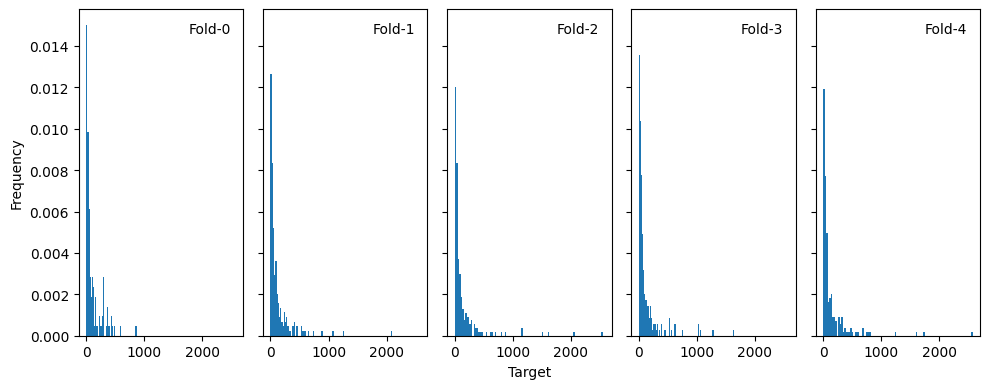

In [7]:
full_train = pd.concat([X_train,y_train],axis=1)

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.hist(full_train[full_train.Fold == i]['TotalGHGEmissions'], bins=100, density=True, label=f'Fold-{i}')
    if i == 0:
        ax.set_ylabel('Frequency')
    if i == 2:
        ax.set_xlabel("Target")
    ax.legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

# Evaluation des modèles 

On va maintenant tester différents modèles d'apprentissage sur notre jeu de données avec les Folds qu'on a créé pour déterminer le plus efficace sur notre problème. Pour cela, on va commencer par faire un premier test en utilisant les paramètres par défaut pour chaque modèle et on va s'intéresser aux résultats obtenus. Pour évaluer ces résultats on peut faire appel à 3 scores différents, le R2, la RMSE et la MAE, qui vont nous permettre de comparer les différents algorithmes.

In [8]:
#Une fonction pour récupérer les index sur le StratifiedKFold
def custom_strat_kfold(df):
    test_index = np.empty([5],dtype='object')
    train_index = np.empty([5],dtype='object')
    for i in range(5) : 
        index = df.loc[df['Fold']==i].index.tolist()
        test_index[i] = index
    
    for i in range(5):
        train_index[i] = [x for x in df.index if x not in test_index[i]]
        
    return(list(zip(train_index,test_index)))

#Une fonction pour calculer différents scores pour évaluer les modèles
def folded_scores(model):
    print(model)
    model_scores = pd.DataFrame(cross_validate(model,X_train,y_train,cv=custom_cv,
                    scoring=('r2','neg_root_mean_squared_error','neg_mean_absolute_error')))
    display(model_scores)
    
    R2 = model_scores['test_r2'].mean()
    RMSE = model_scores['test_neg_root_mean_squared_error'].mean()
    MAE = model_scores['test_neg_mean_absolute_error'].mean()
    
    
    model_mean = pd.DataFrame([[R2,RMSE,MAE]], columns = ['R2','RMSE','MAE'])
    display(model_mean)
    return(model_mean)


### Dummy Regressor

Notre premier modèle sera un Dummy Reggressor, c'est à dire un modèle assez naïf qui donnera uniquement une valeur statistique assez basique comme la médiane ou la moyenne des valeurs. Ça sera évidemment une estimation assez éloignée de la réalité, mais cela nous donne une première idée et un bon point de comparaison pour la suite.

In [9]:
#On crée une cross validation en prenant les index du stratified KFold
custom_cv = custom_strat_kfold(X_train)
#On retire maintenant les variables Fold et Bins qui ne nous servent plus
X_train.drop(['Fold','Bins'],axis=1,inplace=True)

dummy = DummyRegressor(strategy='mean')

dummy_mean = folded_scores(dummy)
dummy_mean.index = (['Dummy Mean'])

DummyRegressor()


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.002001,0.001001,-0.014509,-173.283687,-126.515875
1,0.001999,0.000000,-0.000807,-225.429381,-133.659992
2,0.002000,0.000000,-0.002765,-308.889595,-151.565930
3,0.001000,0.001000,-0.000014,-237.337602,-142.332238
4,0.003002,0.000000,-0.001270,-283.604462,-146.604007


,R2,RMSE,MAE
0,-0.003873,-245.708946,-140.135608


In [10]:
dummy = DummyRegressor(strategy='median')

dummy_median = folded_scores(dummy)
dummy_median.index = (['Dummy Median'])

DummyRegressor(strategy='median')


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.002000,0.000,-0.167208,-185.867642,-98.167911
1,0.002001,0.001,-0.132142,-239.764952,-109.133585
2,0.001000,0.001,-0.105129,-324.272557,-127.089858
3,0.002000,0.000,-0.136577,-253.024798,-115.243538
4,0.001000,0.001,-0.112561,-298.950512,-122.567689


,R2,RMSE,MAE
0,-0.130723,-260.376092,-114.440516


### Régressions linéaires

On va maintenant commencer à travailler avec des algorithmes plus réfléchis. Tout d'abord on va essayer quelques algorithmes de régression linéaire tel que Ridge, Lasso et Elastic Net.

#### Ridge 

In [11]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state = 10)

ridge_mean = folded_scores(ridge)
ridge_mean.index = (['Ridge'])

Ridge(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.108025,0.002001,0.460971,-126.309428,-83.527817
1,0.003000,0.002001,0.507161,-158.193195,-88.404190
2,0.003001,0.001000,0.358557,-247.048945,-112.386231
3,0.003001,0.002000,0.410592,-182.209761,-102.965636
4,0.002001,0.002000,0.470856,-206.169510,-95.638670


,R2,RMSE,MAE
0,0.441627,-183.986168,-96.584509


#### Lasso

In [12]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state =10)

lasso_mean = folded_scores(lasso)
lasso_mean.index = (['Lasso'])

Lasso(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.037008,0.001000,0.494410,-122.328899,-78.927462
1,0.003000,0.001000,0.510680,-157.627471,-84.234519
2,0.003999,0.001005,0.330890,-252.320533,-106.929548
3,0.004001,0.002003,0.438968,-177.769500,-94.811538
4,0.002998,0.002000,0.462519,-207.787264,-92.764554


,R2,RMSE,MAE
0,0.447493,-183.566733,-91.533524


#### Elastic Net

In [13]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(random_state =10)

elastic_mean = folded_scores(elastic)
elastic_mean.index = (['Elastic'])

ElasticNet(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.004001,0.001000,0.341958,-139.558563,-99.655088
1,0.004001,0.001000,0.345661,-182.279062,-103.870430
2,0.003001,0.001001,0.145851,-285.082534,-124.409519
3,0.003000,0.001000,0.318060,-195.991269,-107.070647
4,0.003000,0.001000,0.234550,-247.968092,-116.789170


,R2,RMSE,MAE
0,0.277216,-210.175904,-110.358971


### Neural Network

Pour procéder à une régression non linéaire, on va cette fois utiliser le modèle de NeuralNetwork MLPRegressor.

In [14]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(random_state =10)

MLP_mean = folded_scores(MLP)
MLP_mean.index = (['Neural Network'])

MLPRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.530120,0.001000,0.424347,-130.529952,-85.408179
1,0.479109,0.002001,0.439054,-168.770280,-91.090550
2,0.504446,0.002000,0.227327,-271.144960,-113.572846
3,0.519117,0.001000,0.382402,-186.516215,-94.098841
4,0.526119,0.002000,0.304400,-236.383584,-102.199174


,R2,RMSE,MAE
0,0.355506,-198.668998,-97.273918


### Boosting

On va maintenant regarder des algorithmes de Boosting comme GradientBoosting, LightGBM ou encore XGBoost.

#### Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(random_state =10)

GBR_mean = folded_scores(GBR)
GBR_mean.index = (['Gradient Boosting'])

GradientBoostingRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.207047,0.002001,0.554547,-114.823479,-60.957448
1,0.184042,0.002000,0.667674,-129.902392,-61.299324
2,0.182041,0.002001,0.492205,-219.810307,-86.894406
3,0.181041,0.002001,0.696421,-130.767344,-65.374484
4,0.182041,0.002000,0.688501,-158.185166,-70.917875


,R2,RMSE,MAE
0,0.61987,-150.697738,-69.088707


#### XG Boost

In [16]:
import xgboost as xgb


xg_reg = xgb.XGBRegressor(random_state =10)

xgb_mean = folded_scores(xg_reg)
xgb_mean.index = (['XGBoosting'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=10, ...)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.195044,0.004001,0.505466,-120.984001,-61.906151
1,0.094021,0.004001,0.274983,-191.870976,-77.190262
2,0.088020,0.004001,0.554414,-205.906275,-82.077438
3,0.090020,0.003001,0.662619,-137.855516,-66.356752
4,0.082019,0.003001,0.568378,-186.204140,-78.549241


,R2,RMSE,MAE
0,0.513172,-168.564182,-73.215969


#### LightGBM

In [17]:
import lightgbm as lgb
from matplotlib.pyplot import figure

gbm = lgb.LGBMRegressor(random_state =10)


gbm_mean = folded_scores(gbm)
gbm_mean.index = (['Light GBM'])

LGBMRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.066014,0.002,0.549297,-115.498113,-70.177658
1,0.057013,0.001,0.438519,-168.850641,-75.661030
2,0.061014,0.002,0.500527,-218.001599,-89.755412
3,0.056012,0.001,0.605816,-149.009186,-81.763497
4,0.065015,0.002,0.623051,-174.011870,-82.197237


,R2,RMSE,MAE
0,0.543442,-165.074282,-79.910967


Pour finir on va s'intéresser à un algorithme de bagging : Random Forest.

### Bagging

#### Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(random_state =10)

RFR_mean = folded_scores(RFR)
RFR_mean.index = (['Random Forest'])

RandomForestRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.531120,0.010003,0.550317,-115.367403,-61.546761
1,0.714162,0.011002,0.508378,-157.997783,-63.407104
2,0.490112,0.009002,0.533120,-210.768899,-79.237739
3,0.484109,0.009001,0.665575,-137.250187,-68.693026
4,0.480108,0.008001,0.682991,-159.578016,-69.924949


,R2,RMSE,MAE
0,0.588076,-156.192458,-68.561916


Rassemblons nos données dans un dataset afin de mieux les visualiser et les comparer.

In [19]:
results = pd.concat([dummy_mean,dummy_median,ridge_mean,lasso_mean,elastic_mean,MLP_mean,GBR_mean,xgb_mean,RFR_mean,gbm_mean])
results

,R2,RMSE,MAE
Dummy Mean,-0.003873,-245.708946,-140.135608
Dummy Median,-0.130723,-260.376092,-114.440516
Ridge,0.441627,-183.986168,-96.584509
Lasso,0.447493,-183.566733,-91.533524
Elastic,0.277216,-210.175904,-110.358971
Neural Network,0.355506,-198.668998,-97.273918
Gradient Boosting,0.619870,-150.697738,-69.088707
XGBoosting,0.513172,-168.564182,-73.215969
Random Forest,0.588076,-156.192458,-68.561916
Light GBM,0.543442,-165.074282,-79.910967


<AxesSubplot: ylabel='R2'>

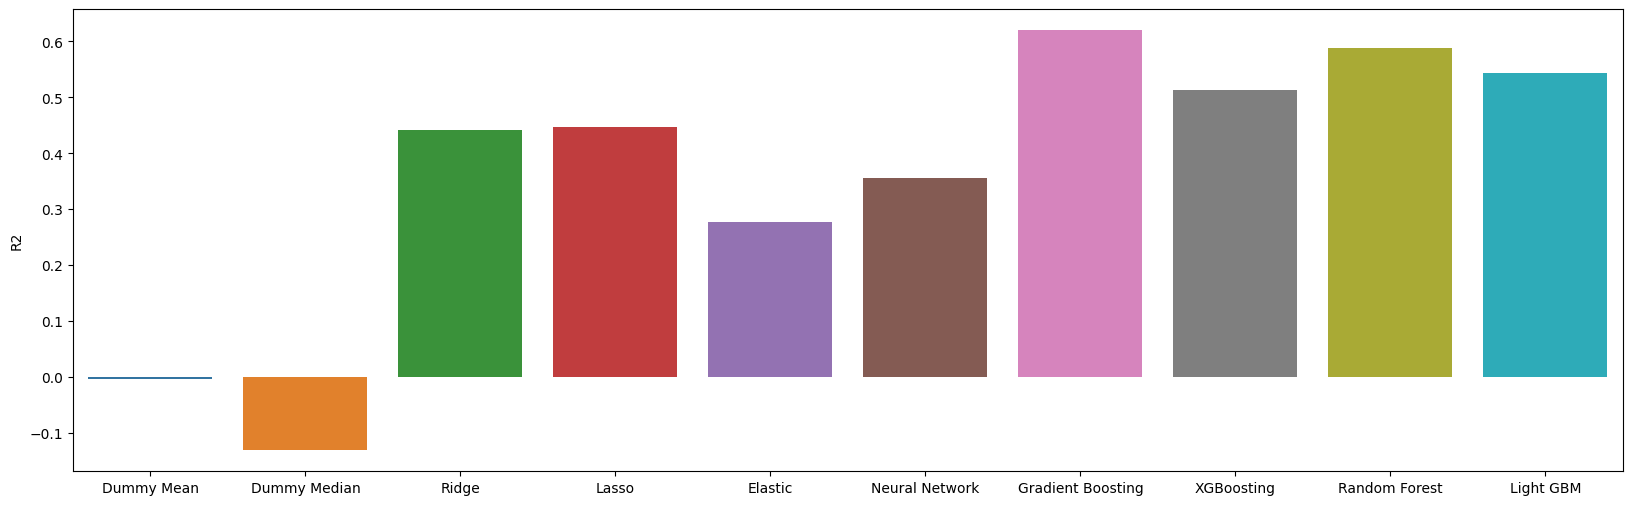

In [20]:
#Affichons ces scores avec un graphique pour les comparer plus facilement
plt.figure(figsize = (20,6))
sns.barplot(data=results,x=results.index,y=results['R2'])

Il apparaît clairement sur ce graph que les modèles les plus efficaces sont Gradient Boosting et Random Forest. On retrouve juste derrière XHBoosting et LightGBM, tandis que tout le reste est bien moins bon.

On va maintenant chercher à améliorer la précision de ces algorithmes en modifiant leurs paramètres à l'aide d'une validation croisée. On sait cependant que nos différents scores ne vont pas forcément varier de la même façon en fonction des paramètres que l'on modifie, on va donc choisir le R-squared comme évaluation principale qu'on va chercher à améliorer. 

# -----------------------------------------------------------------------------------------------------------


## Optimisation


### Gradient Boosting

In [21]:
#Regardons rapidement les paramètres par défaut
display(GBR.get_params())

#Scores avec les paramètres par défaut
display(GBR_mean)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 10,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

,R2,RMSE,MAE
Gradient Boosting,0.61987,-150.697738,-69.088707


In [22]:
opt =  BayesSearchCV(
     GBR,{'learning_rate' : Real(0.05,0.2,prior='log-uniform'),
       'n_estimators' :Integer(50,350),
       'max_depth':Integer(5,40),
       'min_samples_split':[1,2,3],
       'min_samples_leaf' : [1,2,3],
       'max_features' : ['sqrt'],
         'random_state' : [10]},
     n_iter=100,
    cv = custom_cv,
    n_jobs = -1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

0.6561025288606859
OrderedDict([('learning_rate', 0.05383501795922229), ('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 297), ('random_state', 10)])


In [23]:
opt =  BayesSearchCV(
     GBR,{'learning_rate' : Real(0.05,0.06,prior='log-uniform'),
       'n_estimators' :Integer(275,300),
       'max_depth':Integer(5,6),
       'min_samples_split':[4,5],
       'min_samples_leaf' : [1],
       'max_features' : ['sqrt'],
         'random_state' : [10]},
     n_iter=40,
    cv = custom_cv,
    n_jobs = -1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

0.6628495994765498
OrderedDict([('learning_rate', 0.06), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 296), ('random_state', 10)])


In [24]:
opt =  BayesSearchCV(
     GBR,{'learning_rate' : Real(0.059,0.0601,prior='log-uniform'),
       'n_estimators' :[296],
       'max_depth':[6],
       'min_samples_split':[4],
       'min_samples_leaf' : [1],
       'max_features' : ['sqrt'],
         'random_state' : [10]},
     n_iter=40,
    cv = custom_cv,
    n_jobs = -1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

GBR_score = opt.best_score_
GBR_estimator = opt.best_estimator_
GBR_var = opt.cv_results_['std_test_score'].mean()

0.6646446687032168
OrderedDict([('learning_rate', 0.05989696967866094), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 296), ('random_state', 10)])


In [25]:
#On affiche l'estimateur avec ses meilleurs paramètres
GBR_estimator

GradientBoostingRegressor(learning_rate=0.05989696967866094, max_depth=6,
                          max_features='sqrt', min_samples_split=4,
                          n_estimators=296, random_state=10)

## Random Forest

In [26]:
#Paramètres par défaut
display(RFR.get_params())

#Scores avec les paramètres par défaut
display(RFR_mean)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

,R2,RMSE,MAE
Random Forest,0.588076,-156.192458,-68.561916


In [27]:
opt =  BayesSearchCV(
     GBR,{'n_estimators' :Integer(50,350),
       'max_depth':Integer(5,40),
       'min_samples_split':[1,2,3,4],
       'min_samples_leaf' : [1,2,3,4],
       'max_features' : ['sqrt'],
         'random_state' : [10]},
     n_iter=50,
    cv = custom_cv,
    n_jobs = -1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

0.6495468061493916
OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 1), ('n_estimators', 170), ('random_state', 10)])


In [28]:
opt =  BayesSearchCV(
     GBR,{'n_estimators' :Integer(165,180),
       'max_depth':Integer(1,7),
       'min_samples_split':[1],
       'min_samples_leaf' : [1],
       'max_features' : ['sqrt'],
         'random_state' : [10]},
     n_iter=50,
    cv = custom_cv,
    n_jobs = -1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

RFR_score  = opt.best_score_
RFR_estimator = opt.best_estimator_
RFR_var = opt.cv_results_['std_test_score'].mean()

0.6504276977753018
OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 1), ('n_estimators', 180), ('random_state', 10)])


In [29]:
#On affiche l'estimateur avec ses meilleurs paramètres
RFR_estimator

GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_split=1,
                          n_estimators=180, random_state=10)

## XGBoost

In [30]:
#Paramètres par défaut
display(xg_reg.get_params())

#Scores avec les paramètres par défaut
display(xgb_mean)

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 10,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

,R2,RMSE,MAE
XGBoosting,0.513172,-168.564182,-73.215969


In [31]:
opt = BayesSearchCV(
     xg_reg,
     {'eta': Real(0.001,0.5,prior='log-uniform'),
      'min_child_weight': Integer(1,20),
      'max_depth': Integer(1,50),
      'gamma': Integer(0,40),
      'random_state' : [10]},
     n_iter=100,
    cv = custom_cv,
    n_jobs=-1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

XGB_score = opt.best_score_
XGB_estimator = opt.best_estimator_

0.5763308477105011
OrderedDict([('eta', 0.03056364671799187), ('gamma', 0), ('max_depth', 33), ('min_child_weight', 15), ('random_state', 10)])


In [32]:
opt = BayesSearchCV(
     xg_reg,
     {'eta': Real(0.025,0.035,prior='log-uniform'),
      'min_child_weight': Integer(13,17),
      'max_depth': Integer(25,35),
      'gamma': Integer(0,5),
      'random_state' : [10]},
     n_iter=50,
    cv = custom_cv,
    n_jobs=-1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

XGB_score = opt.best_score_
XGB_estimator = opt.best_estimator_
XGB_var = opt.cv_results_['std_test_score'].mean()

0.5777357873737291
OrderedDict([('eta', 0.030303944117766202), ('gamma', 0), ('max_depth', 26), ('min_child_weight', 15), ('random_state', 10)])


In [33]:
#On affiche l'estimateur avec ses meilleurs paramètres
XGB_estimator

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.030303944117766202,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=15, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

Maintenant qu'on a obtenu les meilleurs scores possibles pour chaque modèle, compilons toutes ces informations afin de les comparer plus facilement. Pour chaque modèle, on affichera les scores R2, RMSE et MAE sur la cross validation, ainsi que sur l'échantillon de test. On ajoutera également pour le R2 l'écart type afin d'observer la marge d'erreur.

In [34]:
X_test.drop('Bins',axis=1,inplace=True)

GBR_estimator.fit(X_train,y_train)
RFR_estimator.fit(X_train,y_train)
XGB_estimator.fit(X_train,y_train)

GBR_cv_scores = cross_validate(GBR_estimator,X_train,y_train,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'],cv=custom_cv)
RFR_cv_scores = cross_validate(RFR_estimator,X_train,y_train,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'],cv=custom_cv)
XGB_cv_scores = cross_validate(XGB_estimator,X_train,y_train,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'],cv=custom_cv)

CV_R2_scores = pd.DataFrame([GBR_score,RFR_score,XGB_score])
CV_RMSE_scores = pd.DataFrame([GBR_cv_scores['test_neg_root_mean_squared_error'].mean(),RFR_cv_scores['test_neg_root_mean_squared_error'].mean(),XGB_cv_scores['test_neg_root_mean_squared_error'].mean()])
CV_MAE_scores = pd.DataFrame([GBR_cv_scores['test_neg_mean_absolute_error'].mean(),RFR_cv_scores['test_neg_mean_absolute_error'].mean(),XGB_cv_scores['test_neg_mean_absolute_error'].mean()])

test_R2_scores = pd.DataFrame([GBR_estimator.score(X_test,y_test),RFR_estimator.score(X_test,y_test),XGB_estimator.score(X_test,y_test)])
test_RMSE_scores = pd.DataFrame(np.sqrt([mean_squared_error(y_test,GBR_estimator.predict(X_test)),mean_squared_error(y_test,RFR_estimator.predict(X_test)),mean_squared_error(y_test,XGB_estimator.predict(X_test))]))
test_MAE_scores = pd.DataFrame([mean_absolute_error(y_test,GBR_estimator.predict(X_test)),-mean_absolute_error(y_test,RFR_estimator.predict(X_test)),mean_absolute_error(y_test,XGB_estimator.predict(X_test))])

CV_var = pd.DataFrame([GBR_var,RFR_var,XGB_var])
scores = pd.concat([CV_R2_scores,CV_var,-1*CV_RMSE_scores,-1*CV_MAE_scores,test_R2_scores,test_RMSE_scores,test_MAE_scores],axis=1)

scores.index = ['Gradient Boosting','Random Forest','XGBoost']
scores.columns = ['CV R2','Erreur R2','CV RMSE','CV MAE','Test R2 Scores','Test RMSE Score','Test MAE Scores']
scores

,CV R2,Erreur R2,CV RMSE,CV MAE,Test R2 Scores,Test RMSE Score,Test MAE Scores
Gradient Boosting,0.664645,0.066067,143.844269,69.571175,0.702040,139.227678,63.831484
Random Forest,0.650428,0.056504,145.800706,71.362389,0.682736,143.667067,-63.904826
XGBoost,0.577736,0.061660,159.766169,71.544540,0.567535,167.734527,71.097667


Le modèle qui obtient les meilleurs résultats est ici Gradient Boosting, on le retient donc pour notre étude.

## Analyse des erreurs

On peut s'intéresser aux erreurs de notre estimateur afin de les comprendre et de voir les limites du modèle.
En regardant les erreurs de prédiction sur la cross validation, j'ai pu détecter des erreurs dans mon tri et également identifier ce qui pouvait poser problème à mes estimateurs afin d'en améliorer les performances.

Suite à cela, on peut maintenant regarder les erreurs que l'estimateur choisi fait sur l'échantillon de test, afin de se rendre compte des erreurs qui subsistent. On peut également regarder les quelques lignes où les erreurs sont importantes via SHAP avec un forceplot afin d'essayer de comprendre d'où vient l'erreur (voir plus bas).

In [35]:
#On calcule les prédictions avec l'estimateur
GBR_estimator.fit(X_train,y_train)
predictions  = pd.DataFrame(GBR_estimator.predict(X_test))
predictions.index = y_test.index

#On crée un dataset comprenant les prédictions et les valeurs réelles
data = pd.concat([predictions,y_test],axis=1)
data['Error'] = data['TotalGHGEmissions'] - data[0] 
data['Error%'] = data['Error']/data['TotalGHGEmissions']*100

<AxesSubplot: xlabel='0', ylabel='TotalGHGEmissions'>

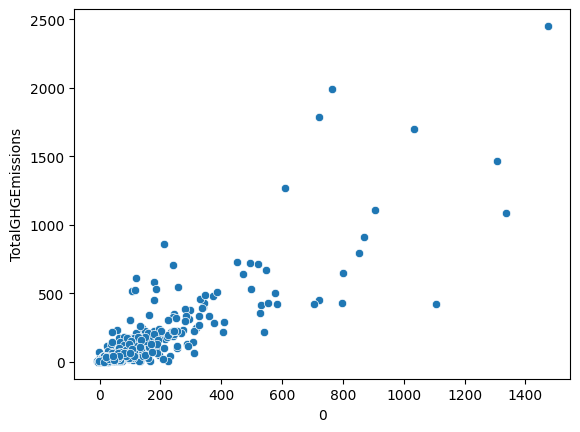

In [36]:
sns.scatterplot(data,x=0,y='TotalGHGEmissions')

<AxesSubplot: xlabel='Error%', ylabel='Count'>

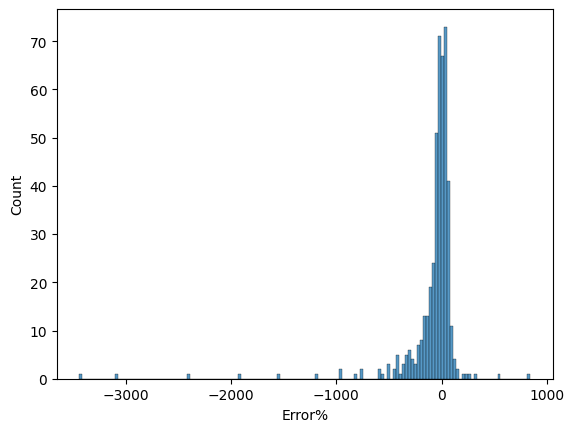

In [37]:
sns.histplot(data,x='Error%' )

In [38]:
data.loc[abs(data['Error%'])>1000]

,0,TotalGHGEmissions,Error,Error%
317,164.963886,8.15,-156.813886,-1924.096766
332,223.796348,6.32,-217.476348,-3441.081449
535,134.248091,4.20,-130.048091,-3096.383131
1030,133.963266,8.07,-125.893266,-1560.015685
302,130.615248,10.24,-120.375248,-1175.539534
522,26.456639,1.06,-25.396639,-2395.909328


In [39]:
data.loc[abs(data['Error%'])>1000].index

Int64Index([317, 332, 535, 1030, 302, 522], dtype='int64')

In [40]:
#On reset les index afin de pouvoir se servir des lignes
X_test.reset_index(inplace=True,drop=True)
data.reset_index(inplace=True,drop=True)

In [41]:
data.loc[abs(data['Error%'])>1000].index

Int64Index([45, 67, 69, 212, 335, 432], dtype='int64')

## Feature Importance

Il serait maintenant intéressant de regarder les features importances globales et locales, afin de comprendre un peu mieux les fonctionnements de nos algorithmes, ainsi que nos résultats. Pour cela on va faire appel à la librairie SHAP.


### Dépendant du modèle

Regardons tout d'abord les features importances de notre meilleur modèle, afin de mieux comprendre son fonctionnement et les variables qu'il utilise en priorité.

Text(0, 0.5, 'Feature Importance Score')

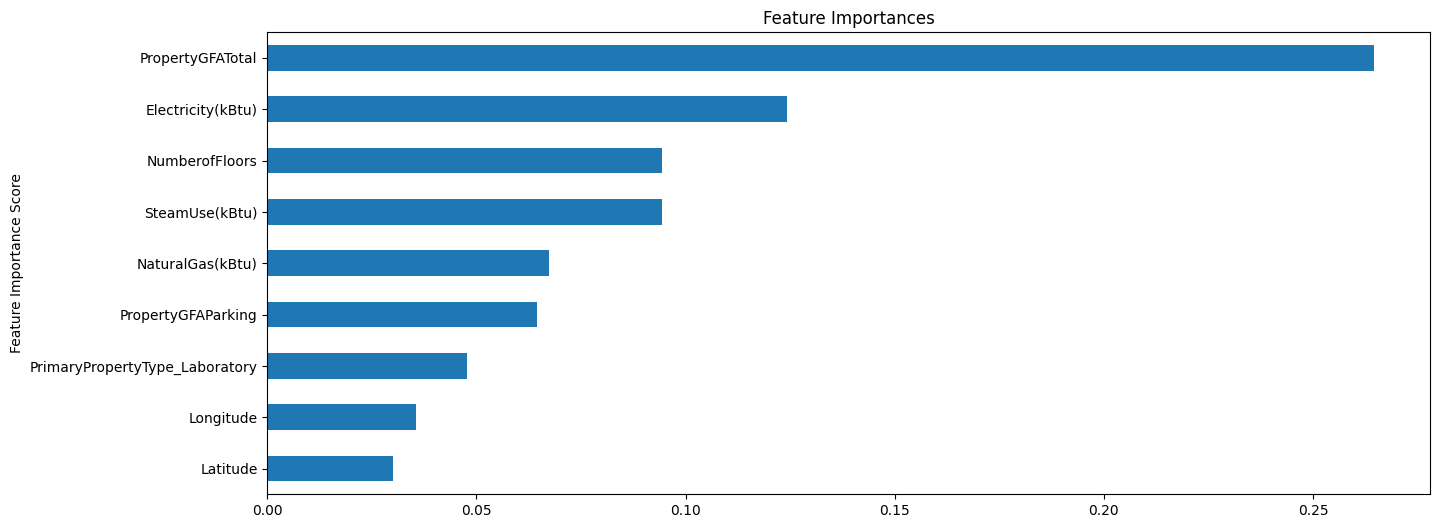

In [42]:
from matplotlib.pyplot import figure
estimator = GBR_estimator

mask = GBR_estimator.feature_importances_> 0.03
figure(figsize=(15,6))
feat_imp = pd.Series(estimator.feature_importances_[mask], X_train.columns[mask]).sort_values(ascending=True)

feat_imp.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Globale

Regardons maintenant quelques graphs afin de se rendre compte des importances globales, c'est à dire indépendamment du modèle utilisé.

In [43]:
import shap
shap.initjs()

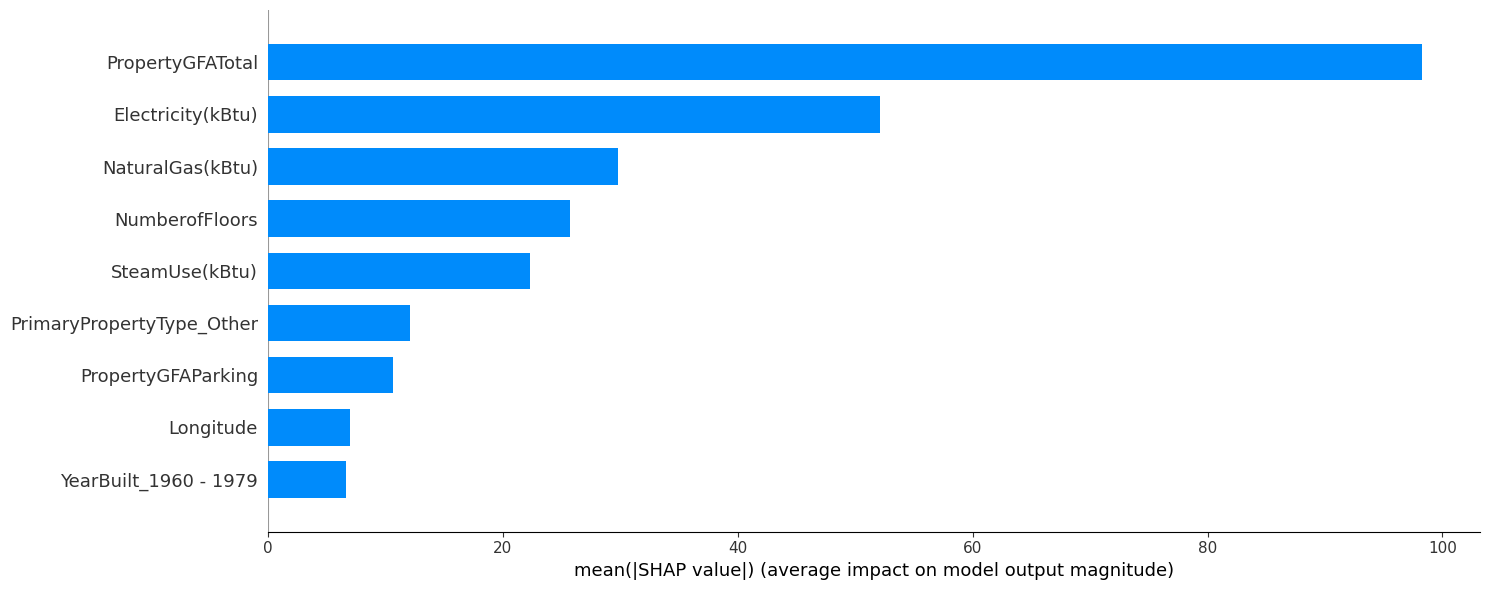

In [44]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,8

GBR_estimator.fit(X_train,y_train)

explainer = shap.TreeExplainer(GBR_estimator,X_train)
shap_values  = explainer.shap_values(X_train,check_additivity=False)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_size = (15,6),plot_type='bar',max_display=9)

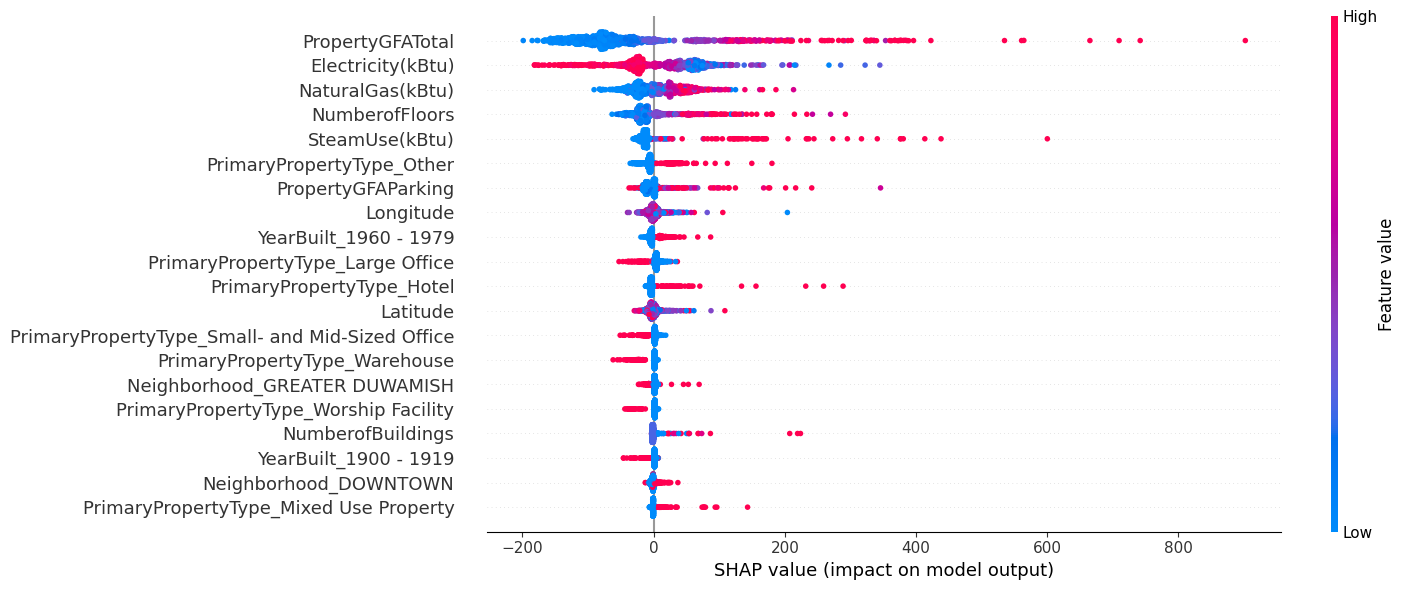

In [45]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_size = (15,6))

### Locale

On peut ici regarder plus en détails quelques lignes qu'on a mises en évidence plus tôt lors de l'analyse d'erreurs afin d'essayer de comprendre pourquoi il se trompe.

In [46]:
explainer = shap.TreeExplainer(GBR_estimator,X_train)
shap_values  = explainer.shap_values(X_test,check_additivity=False)

In [47]:
ind = 67
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_train.columns
)

In [48]:
ind = 69
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_train.columns
)

On peut voir sur ces graphs les influences des différentes variables sur la valeur obtenue ainsi que leurs importances relatives. Il est cependant dur de tirer des conclusions uniquement à partir de cela.

## Energy Star Score

Déterminons maintenant l'influence de l'EnergyStarScore sur nos prédictions. Pour cela, on va utiliser notre estimateur optimal qu'on a obtenu précédemment, voir le résultat obtenu sur la prédiction du set de test, puis on la comparera au résultat obtenu en ajoutant la variable EnergyStarScore dans notre algorithme.

Tout d'abord, on peut remarquer que tous les bâtiments n'ont pas de score attribué donc on va uniquement garder les lignes qui en ont.

In [49]:
#On sélectionne les données qui nous intéressent en retirant les valeurs manquantes
star_score = ml_data.loc[~ml_data['ENERGYSTARScore'].isna()]
star_score.drop('SiteEnergyUseWN(kBtu)',axis=1,inplace=True)

from sklearn.preprocessing import KBinsDiscretizer

#On discrétise ce nouveau dataset comme initialement
discret = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile',random_state=10)
star_score['Bins'] = discret.fit_transform(np.array(star_score['TotalGHGEmissions']).reshape(-1,1))

In [50]:
#On sépare les colonnes pour isoler la variable cible
y_star, X_star = star_score['TotalGHGEmissions'], star_score.drop(columns='TotalGHGEmissions')

#On sépare en train et test avec la stratification
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size=0.3, random_state=10, stratify=X_star['Bins'])

In [51]:
#On crée un échantillon témoin en retirant le score afin de comparer les résultats.
X_temoin_train = X_star_train.drop('ENERGYSTARScore',axis=1)
X_temoin_test = X_star_test.drop('ENERGYSTARScore',axis=1)

X_star_train.drop('Bins',axis=1,inplace=True)
X_star_test.drop('Bins',axis=1,inplace=True)
X_temoin_train.drop('Bins',axis=1,inplace=True)
X_temoin_test.drop('Bins',axis=1,inplace=True)

In [52]:
#On calcule le score sur l'échantillon témoin

GBR_estimator.fit(X_temoin_train,y_star_train)
GBR_estimator.score(X_temoin_test,y_star_test)

0.6952941881390746

In [53]:
#Puis le score sur l'échantillon de test contenant l'ENERGYSTARScore

GBR_estimator.fit(X_star_train,y_star_train)
GBR_estimator.score(X_star_test,y_star_test)

0.7773448300874753

Le résultat avec l'ENERGYSTARScore est bien meilleur, avec une augmentation de 0.08 sur notre score R2.